In [24]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

zipcodes = gpd.read_file('zipcode.geojson')
neighs = gpd.read_file('Maryland_Baltimore_City_Neighborhoods.geojson')
mhinc = pd.read_csv('MASTER_MERGED.csv')
covid = pd.read_csv('COVID_Cleaned_Transposed.csv')
pops = pd.read_csv('PopsByZip.csv')

sjoined = gpd.sjoin(neighs, zipcodes, how='inner',op='intersects')

sjoined.to_csv('spatialJoin.csv')

In [25]:
sjoined = sjoined[['LABEL','zipcode1']]
sjoined = sjoined.rename(columns={'LABEL':'Neigh','zipcode1':'Zip Code'})
mhinc = mhinc[['Neigh','CSA','MHINC','Pop2010']]

merged = pd.merge_ordered(mhinc, sjoined, fill_method='none')
#print(merged[['CSA','Pop2010']])
merged['Zip Code'] = merged['Zip Code'].astype(int)
merged = merged.sort_values(by=['Zip Code'])
print(merged.head())

            Neigh                                    CSA     MHINC  Pop2010  \
852     Poppleton  Poppleton/The Terraces/Hollins Market   20365.8     5086   
668  Mount Vernon                                Midtown   52477.2    15020   
31   Barre Circle             Washington Village/Pigtown   48273.2     5503   
33   Barre Circle             Washington Village/Pigtown   48273.2     5503   
762     Otterbein              Inner Harbor/Federal Hill  100932.2    12855   

     Zip Code  
852     21201  
668     21201  
31      21201  
33      21201  
762     21201  


In [26]:
incomeMeans = []
zipsList = [21227,21207,21230,21251,21229,21237,21287,21231,21226,21206,21222,21225,21211,21208,\
            21205,21218,21234,21202,21201,21213,21210,21209,21216,21236,21217,21224,21215,21212,\
                21223,21214,21239,21228]

zipsList.sort()

for zipcode in zipsList: 
    df1 = merged[merged['Zip Code'] == zipcode]
    incMean = df1['MHINC'].unique().mean()
    incomeMeans.append(incMean)

In [27]:
latestCases = pd.DataFrame()

covid = covid.sort_values(by=['Zip Code'])
latestCases['Zip Code'] = covid['Zip Code'].astype(int)
latestCases['MHINC'] = incomeMeans
#latestCases['Pop2010'] = popSums
latestCases['TotalCases'] = covid.iloc[:,-1].astype(int)
latestCases = pd.merge_ordered(latestCases,pops,fill_method='none')
print(latestCases)

    Zip Code         MHINC  TotalCases  Unnamed: 0  Pop2010
0      21201  48044.111111         447           0    16972
1      21202  53117.988889         813           1    22832
2      21205  38678.157143         668           2    16146
3      21206  53439.028571        1969           3    50846
4      21207  47495.616667        1729           4    48133
5      21208  49056.350000        1384           5    33917
6      21209  64002.133333         746           6    26465
7      21210  82454.580000         110           7    14292
8      21211  56940.450000         269           8    17351
9      21212  73300.960000         806           9    32322
10     21213  38321.400000        1089          10    32733
11     21214  59342.820000         593          11    20564
12     21215  47794.718182        2207          12    60161
13     21216  39209.887500         893          13    32071
14     21217  37689.862500         879          14    37111
15     21218  52487.736364        1244  

In [28]:
latestCases.to_csv('Zip_MHINC_Pop.csv')

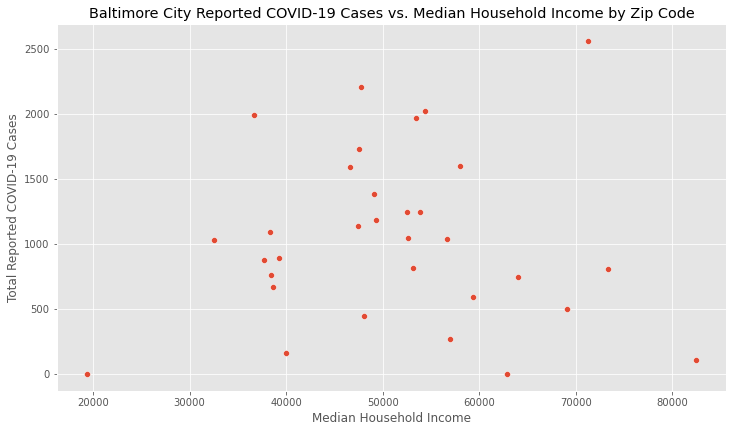

[[1.         0.01662087]
 [0.01662087 1.        ]]


In [29]:
_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
_ = sns.scatterplot(x='MHINC',y='TotalCases',data=latestCases,legend=False)
_ = plt.xlabel('Median Household Income')
_ = plt.ylabel('Total Reported COVID-19 Cases')
_ = plt.title('Baltimore City Reported COVID-19 Cases vs. Median Household Income by Zip Code')
plt.show()

corr = np.corrcoef(latestCases[['MHINC','TotalCases']],rowvar=False)
print(corr)

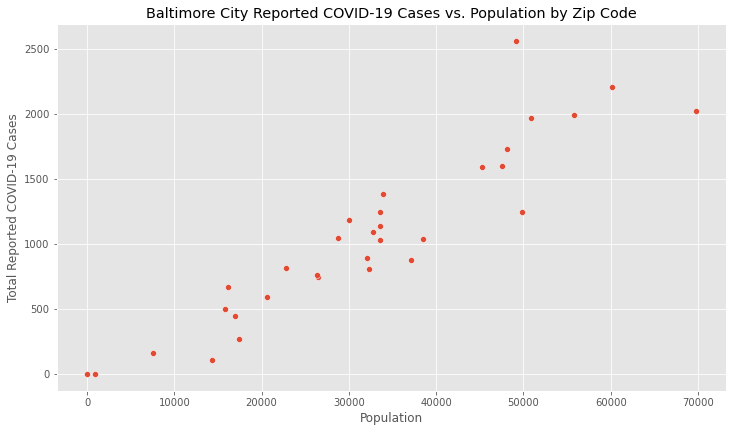

[[1.         0.92594763]
 [0.92594763 1.        ]]


In [30]:
_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
_ = sns.scatterplot(x='Pop2010',y='TotalCases',data=latestCases,legend=False)
_ = plt.xlabel('Population')
_ = plt.ylabel('Total Reported COVID-19 Cases')
_ = plt.title('Baltimore City Reported COVID-19 Cases vs. Population by Zip Code')
plt.show()

corr = np.corrcoef(latestCases[['Pop2010','TotalCases']],rowvar=False)
print(corr)

In [31]:
#pops_greater_65k = latestCases[latestCases['Pop2010'] > 65000]

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0,len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x,bs_y,1)

    return bs_slope_reps, bs_intercept_reps

In [36]:
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(latestCases['Pop2010'].to_numpy(),latestCases['TotalCases'].to_numpy(),200)

#95% C.I. for regression line slopes
cis95 = np.percentile(bs_slope_reps,[2.5,97.5])
print(cis95)

[0.03086872 0.0421733 ]


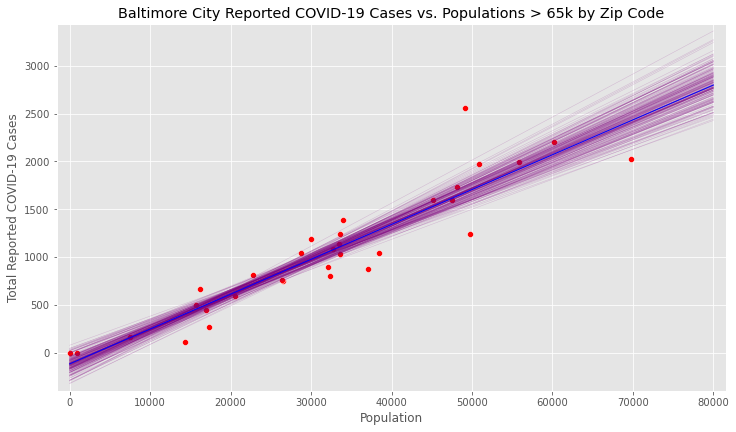

[[1.         0.92594763]
 [0.92594763 1.        ]]


In [46]:
#linear regression with 100 bootstrap lines 
a,b = np.polyfit(latestCases['Pop2010'],latestCases['TotalCases'],1)
x = np.array([0,80000])
y = a * x + b

_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
for i in range(200):
    _ = plt.plot(x,bs_slope_reps[i]*x + bs_intercept_reps[i],
                linewidth=0.5,alpha=0.2,color='purple')
_ = sns.scatterplot(x='Pop2010',y='TotalCases',data=latestCases,legend=False,color='red')
_ = plt.plot(x,y,linewidth=1, color='blue')
_ = plt.xlabel('Population')
_ = plt.ylabel('Total Reported COVID-19 Cases')
_ = plt.title('Baltimore City Reported COVID-19 Cases vs. Populations > 65k by Zip Code')
plt.margins(.02)
plt.show()

corr = np.corrcoef(latestCases[['Pop2010','TotalCases']],rowvar=False)
print(corr)

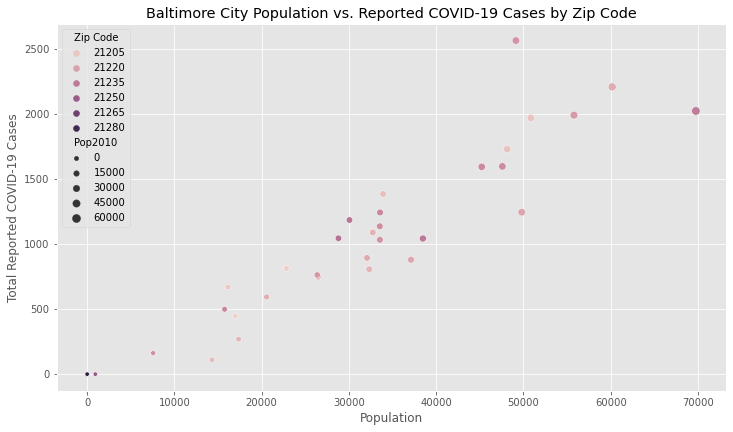

[[1.         0.02084285]
 [0.02084285 1.        ]]


In [49]:
_ = plt.figure(figsize=(12,6.75))
_ = plt.style.use('ggplot')
_ = sns.scatterplot(x='Pop2010',y='TotalCases',data=latestCases,size='Pop2010',hue='Zip Code',legend='brief')
_ = plt.xlabel('Population')
_ = plt.ylabel('Total Reported COVID-19 Cases')
_ = plt.title('Baltimore City Population vs. Reported COVID-19 Cases by Zip Code')
plt.show()

corr = np.corrcoef(latestCases[['Pop2010','MHINC']],rowvar=False)
print(corr)